# Cargar el dataset limpio

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

df = pd.read_csv('../data/processed/beijing_unified_cleaned.csv', index_col='date', parse_dates=True)

df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
date,,,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


# Media de PM2.5 por estación

C:\Users\Antonio\AppData\Local\Temp\ipykernel_15564\866683461.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='station', y='PM2.5', data=df, order=orden_estaciones, palette='Reds')


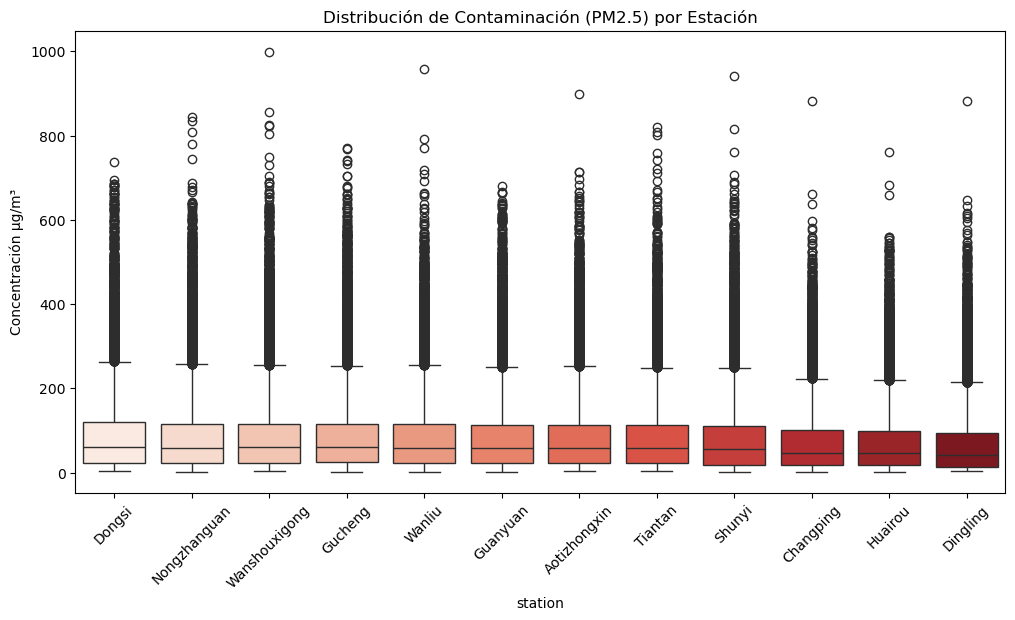

In [3]:
# Definimos la ruta de reportes
ruta_reports = '../reports/'
os.makedirs(ruta_reports, exist_ok=True)

orden_estaciones = df.groupby('station')['PM2.5'].mean().sort_values(ascending=False).index

plt.figure(figsize=(12, 6))
sns.boxplot(x='station', y='PM2.5', data=df, order=orden_estaciones, palette='Reds')
plt.xticks(rotation=45)
plt.title('Distribución de Contaminación (PM2.5) por Estación')
plt.ylabel('Concentración µg/m³')

# Guardamos en reports, definido arriba
plt.savefig(os.path.join(ruta_reports, '01_comparativa_estaciones.png'), bbox_inches='tight')
plt.show()

# Evolución mensual de PM2.5 por estacionalidad

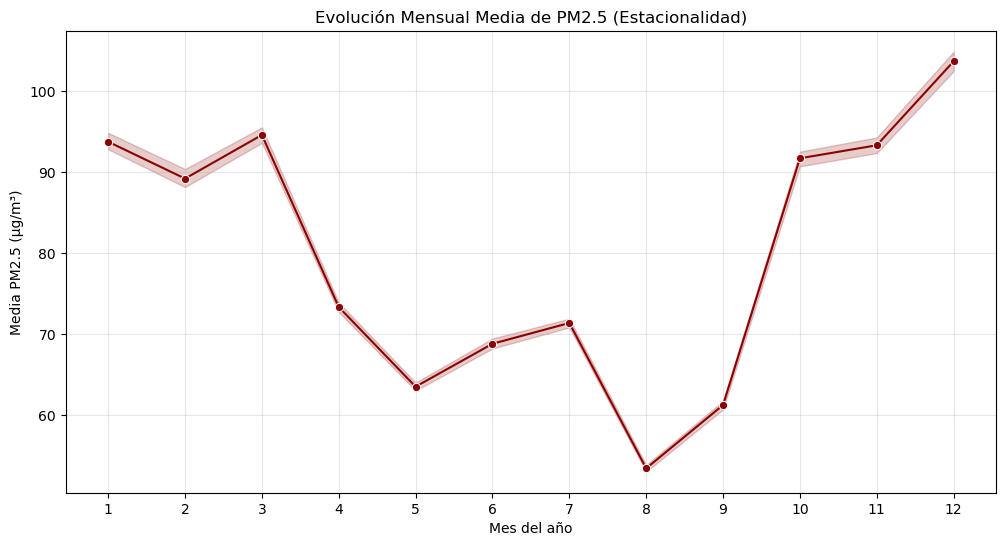

In [4]:
plt.figure(figsize=(12, 6))
# Usamos el índice de fechas para agrupar por mes
sns.lineplot(x=df.index.month, y=df['PM2.5'], estimator='mean', color='darkred', marker='o')

plt.title('Evolución Mensual Media de PM2.5 (Estacionalidad)')
plt.xlabel('Mes del año')
plt.ylabel('Media PM2.5 (µg/m³)')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13))

# GUARDADO
plt.savefig(os.path.join(ruta_reports, '02_estacionalidad_mensual.png'), bbox_inches='tight')
plt.show()

# Análisis horario (hora punta)

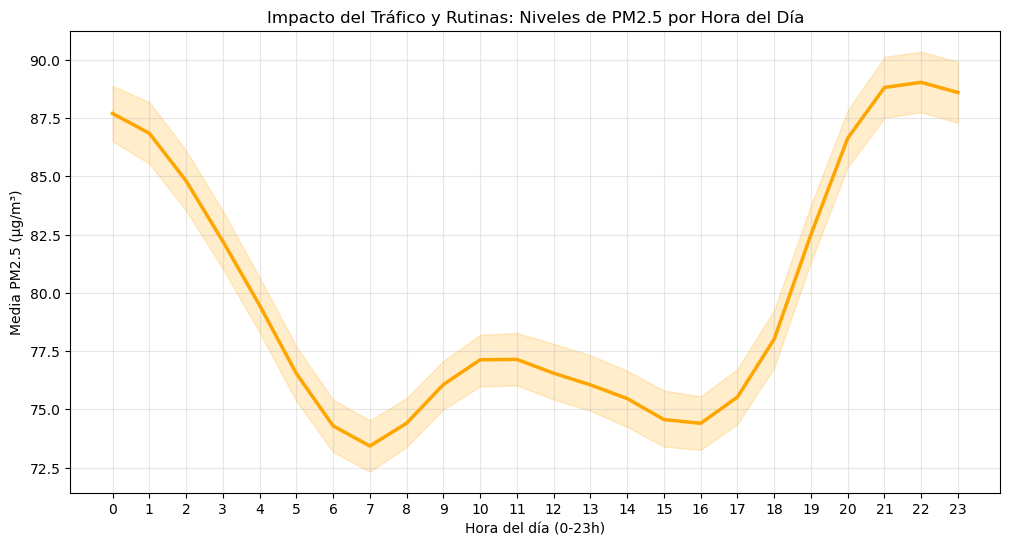

In [12]:
# 1. Extraemos la hora del índice si no la tenemos como columna
if 'hour' not in df.columns:
    df['hour'] = df.index.hour

# 2. Creamos la gráfica de línea para ver la evolución a lo largo del día
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='PM2.5', data=df, estimator='mean', color='orange', linewidth=2.5)

# 3. Personalización para que quede profesional
plt.title('Impacto del Tráfico y Rutinas: Niveles de PM2.5 por Hora del Día')
plt.xlabel('Hora del día (0-23h)')
plt.ylabel('Media PM2.5 (µg/m³)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)

# 4. GUARDADO: La tercera foto para tu carpeta de reports
plt.savefig(os.path.join(ruta_reports, '03_analisis_horario_trafico.png'), bbox_inches='tight')
plt.show()